# Spark streaming with Tweets
Process live tweets for trend analysis using PySpark. 

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
sc = SparkContext()

In [3]:
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [4]:
socket_stream = ssc.socketTextStream('127.0.0.1', 5555)

In [5]:
lines = socket_stream.window(20)

In [6]:
from collections import namedtuple
fields = ('tag', 'count')
Tweet = namedtuple('Tweet', fields)

In [7]:
words = lines.flatMap(lambda text: text.split(' ')) #Splits to a list
hashtags = words.filter(lambda word: word.lower().startswith('#')) # Checks for hashtag calls
pairs = hashtags.map(lambda word: (word.lower(), 1)) # Lower cases the word
counts = pairs.reduceByKey(lambda a, b: a + b) # Reduces
tweets = counts.map(lambda rec: Tweet(rec[0], rec[1])) # Stores in a Tweet Object
# Registers to a table
tweets.foreachRDD(lambda rdd: rdd.toDF().sort(desc('count'), 'tag').limit(10).registerTempTable('tweets_table'))

## Now run TweetRead.py
This is a python client connects to twitter stream using tweepy library and forwards all tracked tweets (in this case, Trump related tweets) to the spark socket stream listener.

In [8]:
ssc.start()

In [9]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Wait for some time to get enough tweets before running below cell

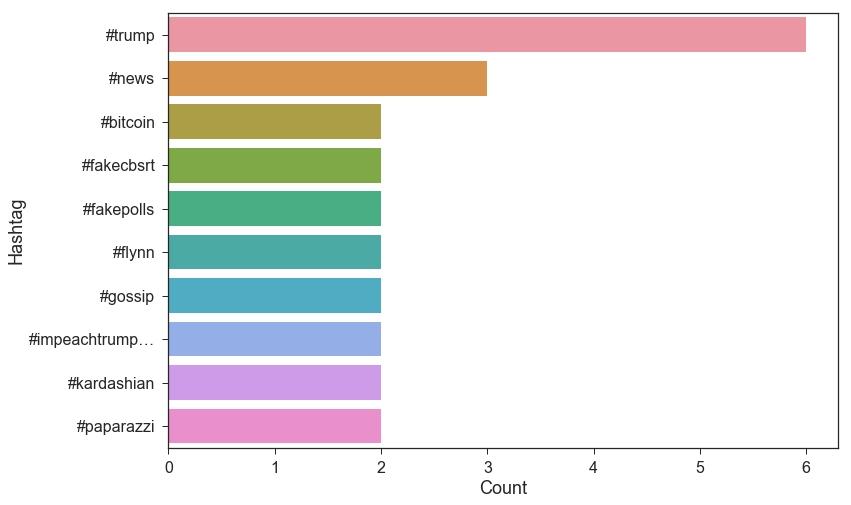

In [10]:
count = 0

while count < 10:    
    time.sleep(3)
    top_10_tweets = sqlContext.sql('select tag, count from tweets_table order by count desc, tag')
    # convert the spark dataframe to a pandas dataframe
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    sns.set_style('ticks')
    sns.plt.figure(figsize = (12, 8))
    b = sns.barplot(x='count', y='tag', data=top_10_df)
    b.set_xlabel('Count', fontsize=18)
    b.set_ylabel('Hashtag', fontsize=18)
    b.tick_params(labelsize=16)
    sns.plt.show()
    count += 1

In [11]:
ssc.stop()